In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Root_insurance_data.csv")

## Let's look at the dataframe info
#df_train.info()
#df.head()
#df_train.ocean_proximity.value_counts()

# generate unique customers
Vehicles = [1]*60 + [2] * 60 + [3] * 60
Drivers = ([1]* 30 + [2]*30)*3
Maritals = (["M"] * 15 + ["S"]*15)*6
Insured = (["unknown"]*5 + ["Y"]*5 + ["N"]*5) *12
ranks = [1,2,3,4,5]* 36

cols = list(df.columns)
df_unique = pd.DataFrame({cols[0]:Insured, cols[1]:Vehicles, cols[2]:Drivers, cols[3]:Maritals, cols[5]:ranks})
df_unique

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,rank
0,unknown,1,1,M,1
1,unknown,1,1,M,2
2,unknown,1,1,M,3
3,unknown,1,1,M,4
4,unknown,1,1,M,5
...,...,...,...,...,...
175,N,3,2,S,1
176,N,3,2,S,2
177,N,3,2,S,3
178,N,3,2,S,4


## Preprocess the data

In [3]:
from sklearn.preprocessing import FunctionTransformer

In [4]:
def one_hot_encode(df):
    df_copy = df.copy()
    
    hot_encoding = pd.get_dummies(df_copy['Currently Insured'])
    df_copy[hot_encoding.columns] = hot_encoding[hot_encoding.columns]
    #hot_encoding = pd.get_dummies(df_copy['Marital Status'])
    #df_copy[hot_encoding.columns] = hot_encoding[hot_encoding.columns]
    #hot_encoding = pd.get_dummies(df_copy['click'])
    #df_copy[hot_encoding.columns] = hot_encoding[hot_encoding.columns]
    
    return df_copy

In [5]:
one_hot = FunctionTransformer(one_hot_encode)

In [6]:
df = one_hot.transform(df)
df.loc[df.click == True, "Click"] = int(1)
df.loc[df.click == False, "Click"] = int(0)
df.loc[df['Marital Status'] == "M", "Marital"] = int(1)
df.loc[df['Marital Status'] == "S", "Marital"] = int(0)
# convert to integers
df = df.astype({"Click": int}) 
#df.loc[df.click == True][:5]
df.describe()

,Number of Vehicles,Number of Drivers,bid,rank,policies_sold,N,Y,unknown,Click,Marital
count,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000
mean,1.965400,1.499900,10.0,3.184100,0.078300,0.344400,0.34190,0.313700,0.187800,0.51910
std,0.807755,0.500025,0.0,1.377242,0.268657,0.475196,0.47437,0.464019,0.390572,0.49966
min,1.000000,1.000000,10.0,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
25%,1.000000,1.000000,10.0,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
50%,2.000000,1.000000,10.0,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000
75%,3.000000,2.000000,10.0,4.000000,0.000000,1.000000,1.00000,1.000000,0.000000,1.00000
max,3.000000,2.000000,10.0,5.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000


In [7]:
df_unique = one_hot.transform(df_unique)
df_unique.loc[df['Marital Status'] == "M", "Marital"] = int(1)
df_unique.loc[df['Marital Status'] == "S", "Marital"] = int(0)
#df.loc[df.click == True][:5]
df_unique.describe()

,Number of Vehicles,Number of Drivers,rank,N,Y,unknown,Marital
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,2.000000,1.500000,3.000000,0.333333,0.333333,0.333333,0.538889
std,0.818774,0.501395,1.418158,0.472719,0.472719,0.472719,0.499876
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.500000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,2.000000,4.000000,1.000000,1.000000,1.000000,1.000000
max,3.000000,2.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
X = df[["Number of Vehicles", "Number of Drivers", "N","Y","unknown","Marital","rank"]].copy()
y_rank = df["rank"].copy()
y_click = df["Click"].copy()
y_sold = df["policies_sold"].copy()

In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone

In [10]:
y = y_click
# tran test split by the policy sold as it has smallest pool
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y)

## Neural Network classification

In [11]:
## We'll use all of these in this notebook
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical

In [12]:
## we first make an empty model
## Sequential means we'll make a group
## of a linear stack of layers
model = models.Sequential()

## you add a layer with .add()
## A Dense layer means a fully connected feedforward layer
## the 16 means the layer is 16 nodes tall
## activation='relu' means the layer uses a relu activation function
## the first layer needs to be told the shape of the input data
model.add(layers.Dense(8, activation='relu', input_shape=(7,)))
# we then add a second layer that is 16 nodes tall
# and uses the relu activation function
# note we don't need the input shape here, 
# it is inferred from the first layer's output
model.add(layers.Dense(4, activation='relu'))

# finally we add the output layer
# this will have a single node, representing a probability
# that the observation has positive sentiment
# this is why the activation is a softmax
model.add(layers.Dense(2, activation='softmax'))

## We can check the architecture of our model with
## model.summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 64        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [13]:
# we compile the network like so
model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [14]:
epoch=20
history = model.fit(X_train,
                        to_categorical(y_train),
                        epochs = epoch,
                        batch_size = 512,
                        validation_data=(X_test,to_categorical(y_test)))

Epoch 1/20
15/15 [==============================] - 2s 125ms/step - loss: 0.4611 - accuracy: 0.8081 - val_loss: 0.4444 - val_accuracy: 0.8148
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 0.4335 - accuracy: 0.8151 - val_loss: 0.4321 - val_accuracy: 0.8148
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 0.4140 - accuracy: 0.8172 - val_loss: 0.4224 - val_accuracy: 0.8148
Epoch 4/20
15/15 [==============================] - 0s 6ms/step - loss: 0.4160 - accuracy: 0.8109 - val_loss: 0.4153 - val_accuracy: 0.8148
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 0.4133 - accuracy: 0.8124 - val_loss: 0.4104 - val_accuracy: 0.8096
Epoch 6/20
15/15 [==============================] - 0s 6ms/step - loss: 0.3990 - accuracy: 0.8219 - val_loss: 0.4063 - val_accuracy: 0.8108
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 0.3938 - accuracy: 0.8233 - val_loss: 0.4036 - val_accuracy: 0.8108
Epoch 8/20
15/15 

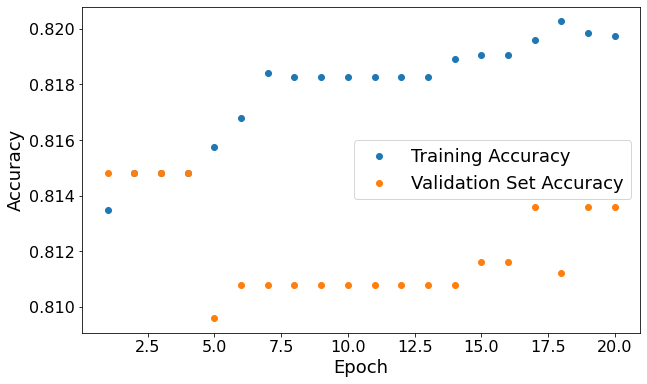

In [15]:
history_dict = history.history
plt.figure(figsize = (10,6))

plt.scatter(range(1,epoch+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,epoch+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

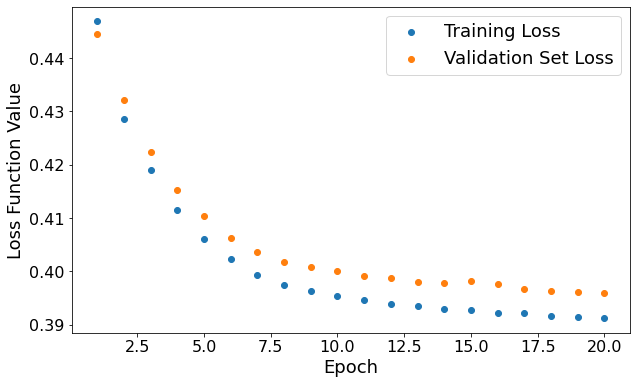

In [16]:
plt.figure(figsize = (10,6))

plt.scatter(range(1,epoch+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,epoch+1), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss Function Value", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [21]:
probs = model.predict(X_train)
auc_train = roc_auc_score(y_train,probs[:,1])
probs = model.predict(X_test)
auc_test = roc_auc_score(y_test,probs[:,1])
print(auc_train,auc_test)

0.7981041408628304 0.7917147049575516


In [22]:
X_unique = df_unique[["Number of Vehicles", "Number of Drivers", "N","Y","unknown","Marital","rank"]].copy()
probs = model.predict(X_unique)
#X_unique

In [23]:
probs_click = probs # dependent on the target y

In [25]:
probs_sold = probs # dependent on the target y, NEED to re-run

In [26]:
df_unique["probs_click"] = probs_click[:,1]
df_unique["probs_sold"] = probs_sold[:,1]

In [ ]:
df_unique.to_csv('Root_probs.csv', index=False)  